# Damped Harmonic Oscillator

The notebook demonstrates how to solve a damped harmonic oscillator driven by a force $F$ as governed by the following equation
\begin{align}
\ddot{x} + 2 \zeta \omega \dot{x} + \omega^2  x = F(t),
\end{align}

where $x$ is the displacement, $\dot{x}$ is the velocity, $c\dot{x}$ a resisting force, $\ddot{x}$ is the acceleration, $\omega=\sqrt{\frac{k}{m}}$ is the angular frequency of the oscillator, $\zeta=\frac{c}{2\sqrt{mk}}$ is the damping ratio, $F(t)$ is the external excitation force, with spring stiffness $k$ and mass $m$. This is a more complicated, but also more complete version of the model for oscillating sptring that we were considering in the last exercise, and wrote as
$m \ddot{x} + k x=0$, after adding the resistance, such that $m\ddot{x} + c \dot{x} +kx=0$.

We can define $y=\dot{x}$ so that the ODE equations to be solved are
1. $\dot{x} = y$, and 
2. $\dot{y} = F(t)-2\zeta\omega y -\omega^2x$.

We will also assume that $F(t) = F_m \sin(\omega_d t)$.

The tutorial contains functions that use three numerial methods - Euler, Midpoint and Runge-Kutta - and Scipy integrate ODE solver to solve the system. 

Five exercises are given to help you explore the charateristics of the sysetm.
1. simple harmonic oscillator;
2. underdamped harmonic oscillator;
3. critically damped harmonic oscillator;
4. overdamped harmonic oscillator;
5. harmonic oscillator driven by sinusoidal external excitation force;

# Warm-up
Could you derive the expressions of $\omega_0$ and $\zeta$ in terms of $k$, $m$, and $c$, where $k$ is the stiffness constant, $m$ is the mass, $c$ is the viscous damping coefficient.

In [21]:
%pip install -q ipywidgets matplotlib numpy scipy pandas 
#install packages used by this tutorial.
import numpy  as np
import pandas as pd
import ode    as odeLib        # our self-defined ODE routines in ode.py.
import matplotlib.pyplot as plt
from dataclasses import dataclass,astuple,asdict # for C-like structure
from   scipy                import integrate
from   ipywidgets           import *
from   IPython.display      import display

Note: you may need to restart the kernel to use updated packages.


In [22]:
#
# define problem
#
# we now use a classs to collect all parameter for the ODE function
@dataclass
class parameters:                 # parameters for functions, default values
    zeta   :float  = 0
    omega  :float = 2.*np.pi*1.0
    Fm     :float  = 0
    omegad :float = omega
    ndim   :int  = 2
    
# 
# define functions for ODE solvers, need to be in f(t,x,par) format
#
# damped harmonic oscillator, dx/dt for dotx and x.


def f0(t,x,par):                  # dx/dt      = y
    return x[1]

def f1(t,x,par):                  
    # If with driven sinusoidal force, d^2 x/ dt^2 = dy/dt = f - 2*zeta*omega*dotx - omega^2*x + Fm*sin(omegad*t).
   
    return par.Fm*np.sin(par.omegad*t) -2.*par.zeta*par.omega*x[1] - par.omega**2*x[0] 

def ode_solver(xinit, time, method, par):
    # method supports three options
    # - 'euler'
    # - 'midpoint'
    # - 'runge_kutta'
    
    nstep = len(time)
    xout  = np.empty((nstep,par.ndim))
    
    hs    = time[1] - time[0]
    
    # important! here, we need to make a copy, we do not want to override anything in xinit, EVER
    # this is nicer but did not work with the interactive code
    #xtmp = xinit.copy()
    xtmp = np.empty(np.shape(xinit))
    for i in range(par.ndim):
        xtmp[i] = xinit[i]
    
    f     = [f0, f1]
    for i, t in enumerate(time):
        xout[i][:] = xtmp
        if method  == 'euler':
            xtmp   = odeLib.euler(t,xtmp,f,par.ndim,hs,par)
        elif method == 'midpoint':
            xtmp   = odeLib.midpoint(t,xtmp,f,par.ndim,hs,par)
        elif method == 'runge_kutta':
            xtmp   = odeLib.runge_kutta(t,xtmp,f,par.ndim,hs,par)
    return xout

# Method 2
Sovle the ODE system with the ODE solver in Scipy integrate. 

In [23]:
#
# we need to redefine the call for argument lists
#
def dxdt(x, t, zeta,omega,Fm,omegad,ndim): # swap order for scipy and use a tupel of arguments
    f0 = x[1]
    f1 = Fm*np.sin(omegad*t) -2.*zeta*omega*x[1] - omega**2*x[0] 
    return [f0, f1]

def ode_solver_scipy(xInit,t, par):
    #print(astuple(par))
    # this is ugly, but we cannot pass a class??!
    sol     = integrate.odeint(dxdt, xInit, t, astuple(par), rtol=1e-8)
    #print(np.shape(sol))
    return sol


# General driver routine
This is a routine we will reuse for plotting and doing numerical experiments.

In [94]:
def driver(zeta = 0, omega = 1.*np.pi, Fm = 0, omegad = 2.*np.pi, xInit0 = [0, 0.], 
           method = 'euler', plot_feature=['k',2], tmax = 10, nsteps = 100, plabel = None):
    
    err = False
    
    # method: currently support four - 'euler', 'midpoint', 'runge_kutta', 'scipy'.
    # plot_feature: first param - line color; second param - line thickness.
    
    t      = np.linspace(0., tmax, nsteps)
    
    # set constants for the system
    par        = parameters()
    par.zeta   = zeta
    par.omega =  omega
    par.Fm     = Fm
    par.omegad = omegad
    
    if   ((method == 'euler')or(method=='midpoint')or(method=="runge_kutta")):
        x    = ode_solver(xInit0,t, method, par)
    elif method == 'scipy':
        x    = ode_solver_scipy(xInit0,t, par) 
    else:
        print('error, method', method, ' not define')
        return False,0
   
    #select = np.arange(nsteps-10,nsteps)
    #print(select)
    
    
    maxA       = np.max(abs(x[:,0]))
    
    if(plabel):
        plot_label = plabel
    else:
        plot_label='omegad = '+str(omegad)
        #plot_label=method
    plt.plot(t, x[:,0], plot_feature[0], label=plot_label, linewidth=plot_feature[1])
    plt.grid()
    #plt.ylim(-1., 1.)
    plt.xlabel("time, $t$")
    plt.ylabel("displacement, $x$")
    plt.legend()
    
    err = True
    return err, maxA

# Exercise 1
Simple harmonic oscillator. This example has no driving force, and compares the different solution methods.

(True, 132.82036327303058)

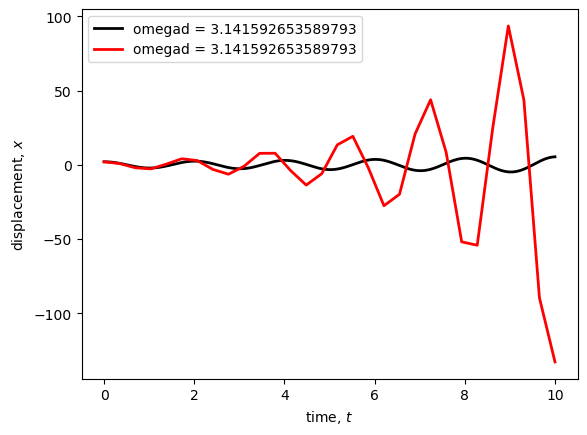

In [95]:
fig    = plt.figure()
omega  = 1*np.pi;
zeta=0;
omegad=omega;F=0

xinit= [2.,0.]

# I tested this and that
driver(zeta, omega,F,omegad,xinit, method = 'euler',    plot_feature = ['k',2],nsteps=500)
driver(zeta, omega,F,omegad,xinit, method = 'midpoint', plot_feature = ['r-',2],nsteps=30)



Comment on the difference in solution, and verify the results from your experiments. Can you use this setup, or modifications thereof to approximate your experimental results?

# Exercise 2 
Damped harmonic oscillator. Now introduce some damping, and compare the mid point and Runge Kutta methods, for example.

(True, 4.711410740531346)

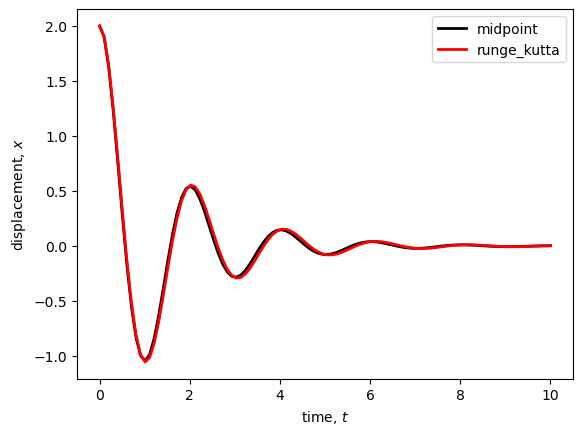

In [26]:
fig    = plt.figure()
zeta=0.2
driver(zeta, omega,F,omegad,xinit, method = 'midpoint',    plot_feature = ['k',2])
driver(zeta, omega,F,omegad,xinit, method = 'runge_kutta', plot_feature = ['r-',2])


# Exercise 3

Critically damped harmonic oscillator. Let us switch to the built-in scipy ODE solver, and now explore different damping values, between 0.1, 0.5, 1, and 1.5.


(True, 2.3089597862021)

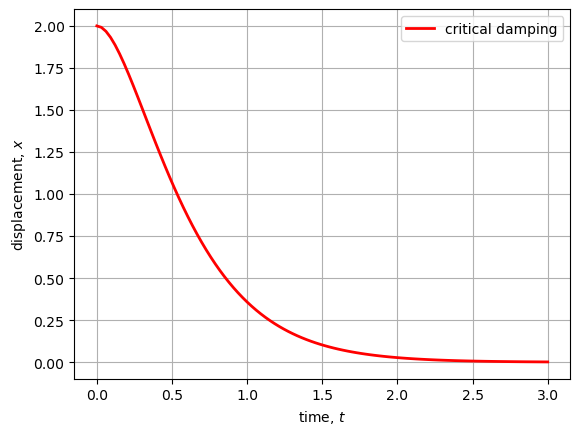

In [27]:
fig = plt.figure()

zeta=1
driver(zeta, omega,F,omegad,xinit, method = 'scipy', plot_feature = ['r-',2],tmax=3,plabel="critical damping")


# Exercise 4 
Overdamped harmonic oscillator

(True, 2.0)

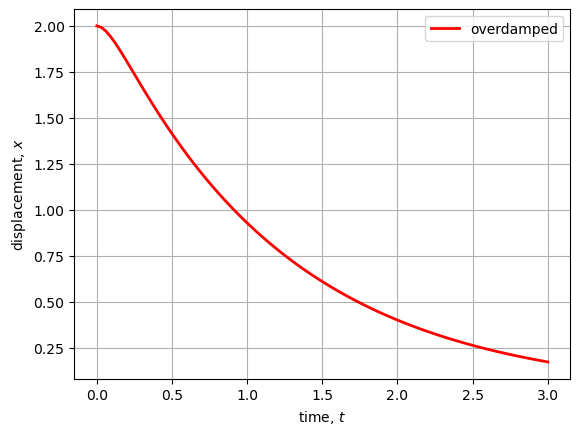

In [28]:
fig = plt.figure()
zeta=2
driver(zeta, omega,F,omegad,xinit, method = 'scipy', plot_feature = ['r-',2],tmax=3,plabel="overdamped")

# Exercise 5 
Driven harmonic oscillator. <br>

Switch on the driving force and experiment. 

Here are a few scenarios to explore. <br>
What happens to the freqeuncies if you change the driving amplitudes? <br>
What happens to the peak amplitudes if you change the ratio of driving frequencies to the oscillator angular frequency? <br>

(True, 49.86812266732722)

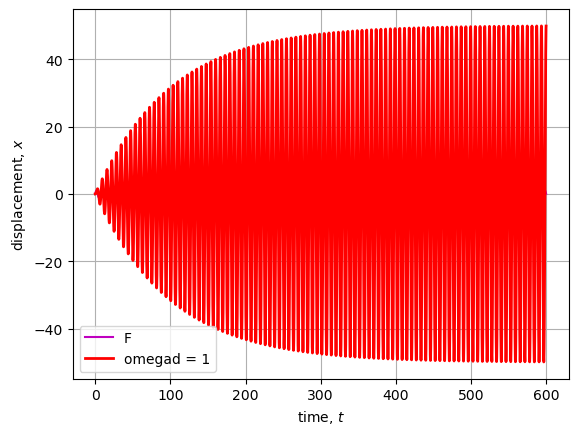

In [96]:
zeta = 0.01;
F=1;omega=1;

trange=600
omegad=1
tplot = np.linspace(0,trange,num=1000);yd=F*np.sin(omegad*tplot); 
plt.plot(tplot,yd,'m-',label="F")
driver(zeta, omega,F,omegad,method = 'scipy', plot_feature = ['r-',2],nsteps=10000,tmax=trange)

#driver(zeta, omega,F,  1, method = 'scipy', plot_feature = ['g-',2],plabel="wd = 1",nsteps=1000,tmax=trange)
#driver(zeta, omega,F,  2, method = 'scipy', plot_feature = ['b-',2],plabel="wd = 2",nsteps=1000,tmax=trange)


# Interactive plot
The following cell block provides an interactive plot for wide ranges of parameters. (NOTE: to disable auto-scrolling of the results, click the left bar of the figure cell or right-click the figure cell to choose 'disable auto-scrolling outputs'.)

In [10]:
    
# def driver(zeta = 0, omega = 2.*np.pi, Fm = 0, omegad = 2.*np.pi, xInit0 = [1., 0.], 
#           method = 'euler', plot_feature=['k',2], tmax = 10, nsteps = 100, plabel = None):

w = interactive(driver, 
                zeta   = (0., .3, 0.01), 
                omega  = fixed(1*np.pi),
                Fm     = fixed(1.),
                omegad = (np.pi*0.01, np.pi*2., 0.01),
                method = fixed('scipy'), 
                xInit0 = fixed([1,0]),
                plot_feature = fixed(['b-',2]),
                tmax = fixed(75),
                nsteps = fixed(5000),
                plabel = fixed(None)
               )
display(w)

interactive(children=(FloatSlider(value=0.0, description='zeta', max=0.3, step=0.01), FloatSlider(value=6.2831…